In [1]:
#!/bin/bash
# https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri/data
# !kaggle datasets download sartajbhuvaji/brain-tumor-classification-mri
# !unzip "./brain-tumor-classification-mri.zip"


In [2]:
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, precision_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import pandas as pd
from aux import ImagesMRIDataset, split_for_cross_validation, get_training_testing_data, plot_data, get_data_distribution, split_traing_data

class EarlyStopping():
    def __init__(self, path : str, patience=5, threshold=1e-4):
        self.patience = patience
        self.threshold = threshold
        self.min_loss = 10000
        self.steps_till_stop = 0
        self.path = path

    def continue_training(self, model, loss):
        if(loss < self.min_loss - self.threshold):
            self.min_loss = loss
            self.steps_till_stop = 0
            torch.save(model.state_dict(), self.path)
            return True
        if (loss >= self.min_loss - self.threshold):
            self.steps_till_stop += 1
            if (self.steps_till_stop == self.patience): return False
        return True
    
    def load_model(self, model):
        model.load_state_dict(torch.load(self.path, weights_only=True))
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        return model


In [10]:
SIZE = (100, 100)
train_transform = A.Compose([
    A.Resize(height=SIZE[0], width=SIZE[1]),  
    A.RandomGamma(gamma_limit=(80, 120), p=1.0), 
    A.HorizontalFlip(p = 0.5),
    A.ShiftScaleRotate(p = 0.5),
    A.CLAHE(clip_limit=5.0, tile_grid_size=(8, 8), p=1.0), 
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.8), 
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

test_transformations = A.Compose([
    A.Resize(height=SIZE[0], width=SIZE[1]),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

def compute_train_transformations(image):
    image = train_transform(image=image)["image"]
    return np.array(image.transpose((2, 0, 1)), dtype=np.float32)
    
def compute_test_transformation(image):
    image = test_transformations(image=image)["image"]
    return np.array(image.transpose((2, 0, 1)), dtype=np.float32)


/home/alf/anul4/InvatareSupervizataTema2/venv/lib/python3.12/site-packages/albumentations/core/validation.py:45: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [9]:
def training_loop(model, criterion, optimizer, dataloader : DataLoader):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  current_training_loss = 0
  all_train_labels, all_train_preds = [], []
  model.train()
  for idx, (images, labels) in enumerate(dataloader):
    images, labels = images.to(device), labels.to(device)
    output = model(images)
    output = output.to(device)
    loss = criterion(output, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    current_training_loss += loss.item()
    all_train_preds.extend(output.argmax(dim=1).cpu().numpy())
    all_train_labels.extend(labels.cpu().numpy())
  return 2 * current_training_loss / len(dataloader),  all_train_preds, all_train_labels


def validation_loop(model, criterion, dataloader : DataLoader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    all_val_labels, all_val_preds = [], [],
    current_validation_loss = 0
    model.eval()
    with torch.no_grad():
      for idx, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        output = output.to(device)
        loss = criterion(output, labels)
        current_validation_loss += loss.item()
        all_val_labels.extend(labels.cpu().numpy())
        all_val_preds.extend(output.argmax(dim=1).cpu().numpy())
    return 2 * current_validation_loss / len(dataloader),  all_val_preds, all_val_labels

def train_model(model, epochs, data, criterion, optimizer, lr_scheduler, early_stopping : EarlyStopping):
  training_loss = [] 
  validation_loss = []
  training_accuracy = []
  validation_accuracy = []
  maxim_accuracy = -1
  for i in range(epochs):
      Tloss, train_pred, train_labels = training_loop(model, criterion, optimizer, data["train"])
      Vloss, all_val_preds, all_val_labels = validation_loop(model, criterion, data["validation"])
      if (not early_stopping.continue_training(model, Vloss)):
         print("Loss-ul nu a scazut de ceva vreme, a intervenit early stopping")
         break
      lr_scheduler.step(Vloss)
      training_loss.append(round(Tloss, 3))
      validation_loss.append(round(Vloss, 3))
      training_accuracy.append(round(accuracy_score(train_pred, train_labels), 3))
      validation_accuracy.append(round(accuracy_score(all_val_labels, all_val_preds), 3))
      if (maxim_accuracy < validation_accuracy[-1]):
        print(f"best model found at {i}", f"loss is {validation_loss[-1]}", f"accuracy is {validation_accuracy[-1]}")
        maxim_accuracy = validation_accuracy[-1]
      else:
         print(f"epoca {i}", f"loss is {validation_loss[-1]}", f"accuracy is {validation_accuracy[-1]}")
  return training_loss, validation_loss, training_accuracy, validation_accuracy

def test_model(model, dataloader, criterion):
    _, preds, labels = validation_loop(model, criterion, dataloader)
    precision = precision_score(preds, labels, average='macro') 
    recall = recall_score(preds, labels, average='macro')
    f1 = f1_score(preds, labels, average='macro')
    acc = accuracy_score(preds, labels)
    return precision, recall, f1, acc, confusion_matrix(preds, labels)


In [11]:
class Net(nn.Module):
    def __init__(self,  width : int, expansion : int):
        super().__init__()
        self.relu = nn.ReLU()
        self.width1 = width
        self.conv1 = nn.Conv2d(3, self.width1, kernel_size=(3, 3))
        self.bn1 = nn.BatchNorm2d(self.width1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

        self.width2 = self.width1 * expansion
        self.conv2 = nn.Conv2d(self.width1, self.width2, kernel_size=(3, 3))
        self.bn2 = nn.BatchNorm2d(self.width2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

        self.width3 = self.width2 * expansion
        self.conv3 = nn.Conv2d(self.width2, self.width3, kernel_size=(5, 5))
        self.bn3 = nn.BatchNorm2d(self.width3)
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

        self.width4 = self.width3 * expansion
        self.conv4 = nn.Conv2d(self.width3, self.width4, kernel_size=(3, 3))
        self.bn4 = nn.BatchNorm2d(self.width4)
        self.maxpool4 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

        self.width5 = self.width4 * expansion
        self.conv5 = nn.Conv2d(self.width4, self.width5, kernel_size=(3, 3))
        self.bn5 = nn.BatchNorm2d(self.width5)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classification_layer = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(self.width5, self.width4),
            nn.Dropout(p=0.5),
            nn.Linear(self.width4, self.width3),
            nn.Dropout(p=0.5),
            nn.Linear(self.width3, 4),
            nn.LogSoftmax(dim=1),
        )
        
    def forward(self, x : torch.tensor):
        x = self.maxpool1(self.relu(self.bn1(self.conv1(x))))
        x = self.maxpool2(self.relu(self.bn2(self.conv2(x))))
        x = self.maxpool3(self.relu(self.bn3(self.conv3(x))))
        x = self.maxpool4(self.relu(self.bn4(self.conv4(x))))
        x = self.avgpool(self.relu(self.bn5(self.conv5(x))))
        return self.classification_layer(x)

model_try = Net(width=8, expansion=3)

for module in model_try.modules():
    param_count = sum(p.numel() for p in module.parameters() if p.requires_grad)
    print(f"Layer Type: {module}, Number of Parameters: {param_count}")

Layer Type: Net(
  (relu): ReLU()
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 24, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(24, 72, kernel_size=(5, 5), stride=(1, 1))
  (bn3): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(72, 216, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(216, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode

In [13]:
def show_plot(list1, list2, label1, label2, title):
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=range(1, len(list1) + 1), y=list1, label=label1, marker='o')
    sns.lineplot(x=range(1, len(list2) + 1), y=list2, label=label2, marker='o')
    plt.xlabel(label1)   
    plt.ylabel(label2)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def show_matrix(matrix):
    cm_display = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = [0, 1, 2, 3])
    cm_display.plot()
    plt.tight_layout()
    plt.show()
    
def add_info(info_data, precision, acc, recall, f1):
    info_data["precision"].append(precision)
    info_data["accuracy"].append(acc)
    info_data["recall"].append(recall)
    info_data["f1Score"].append(f1)
    return info_data


def create_cross_validation_data(data_chunks, test_data, current : int, train_transform, test_transform, batch_size):
    training_data = []
    for idx, chunk in enumerate(data_chunks):
        if (idx == current):
            continue
        training_data += chunk
    return {
        "train": DataLoader(ImagesMRIDataset(training_data, transformations=train_transform), batch_size=batch_size, shuffle=True, drop_last=True),
        "validation": DataLoader(ImagesMRIDataset(data_chunks[current], transformations=test_transform), batch_size=batch_size, shuffle=True),
        "test": DataLoader(ImagesMRIDataset(test_data, transformations=test_transform), batch_size=batch_size, shuffle=True)
    }

best model found at 0 loss is 4.034 accuracy is 0.479
best model found at 1 loss is 1.702 accuracy is 0.645
best model found at 2 loss is 1.672 accuracy is 0.66
best model found at 3 loss is 1.327 accuracy is 0.757
epoca 4 loss is 2.142 accuracy is 0.596
epoca 5 loss is 1.375 accuracy is 0.757
epoca 6 loss is 1.532 accuracy is 0.738
best model found at 7 loss is 1.038 accuracy is 0.804
epoca 8 loss is 1.143 accuracy is 0.783
best model found at 9 loss is 0.971 accuracy is 0.815
epoca 10 loss is 1.187 accuracy is 0.774
epoca 11 loss is 0.982 accuracy is 0.809
epoca 12 loss is 1.233 accuracy is 0.764
epoca 13 loss is 0.953 accuracy is 0.796
best model found at 14 loss is 0.861 accuracy is 0.847
epoca 15 loss is 0.869 accuracy is 0.834
epoca 16 loss is 0.849 accuracy is 0.836
best model found at 17 loss is 0.816 accuracy is 0.86
epoca 18 loss is 1.082 accuracy is 0.843
epoca 19 loss is 1.287 accuracy is 0.777
best model found at 20 loss is 0.679 accuracy is 0.868
best model found at 21 lo

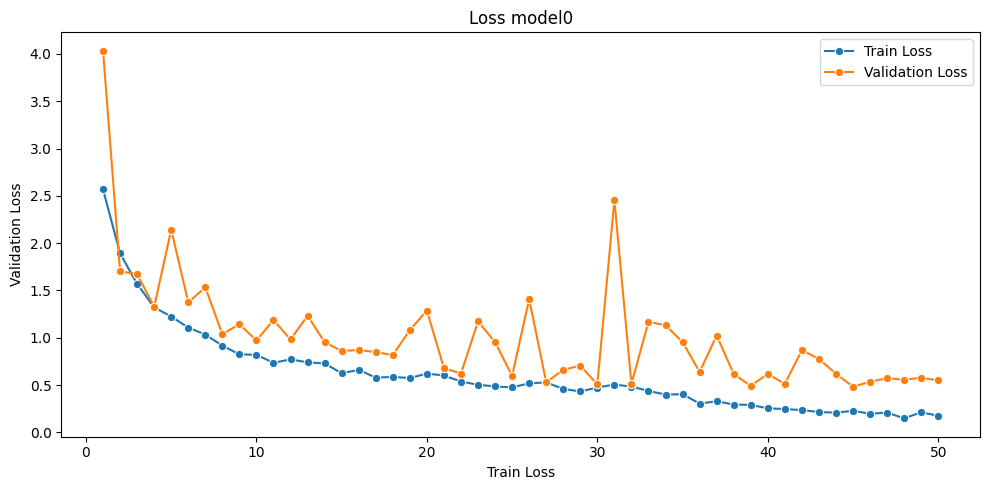

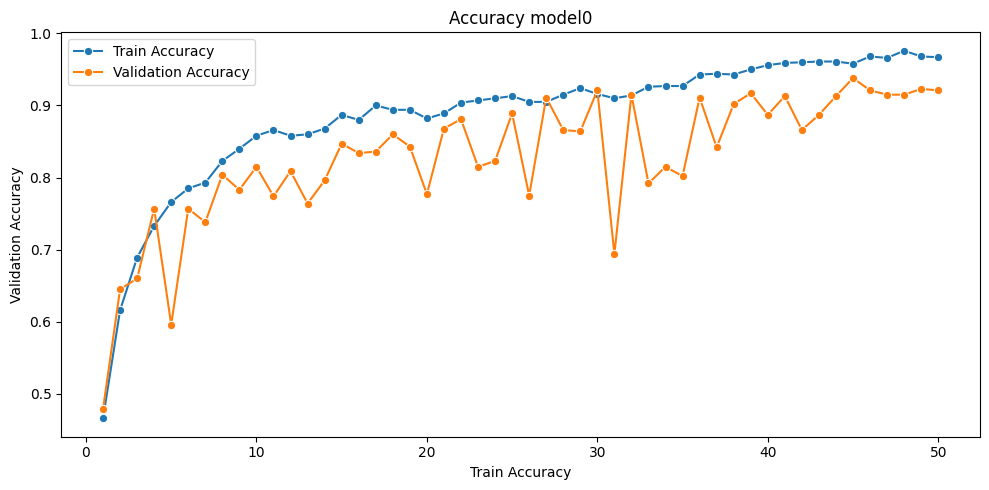

0.7766497461928934

In [14]:
K = 5
BALANCED = True
training_info, test_info = get_training_testing_data(BALANCED)
training_info, validation_info = split_traing_data(training_info, 0.2)
data_chunks = split_for_cross_validation(training_info, K)

grid_parameters = {
    "batch_size": [5, 10, 25, 50, 100],
    "epochs" : [50],
    "lr": [1e-1, 1e-2, 1e-3, 1e-4],
    "weight_decay": [1e-3, 1e-4],
    "optimizer_patience" : [3, 4, 5],
    "lr_factor": [0.1, 0.3, 0.5, 0.7],
    "width": [8, 16],
    "expansion" : [2, 3, 4],
    "early_stopping_patience" : [10],
}

def compute_functions(model : Net, parameters):
    optimizer = torch.optim.Adam(model.parameters(), lr=parameters["lr"], weight_decay=parameters["weight_decay"])
    return torch.nn.CrossEntropyLoss(), optimizer, torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 
                patience=parameters["optimizer_patience"], factor=parameters["lr_factor"])

def compute_cross_validation(parameters, train_transforms, test_transforms):
    info_test = {"precision": [], "recall": [], "f1Score" : [], "accuracy" : []}
    for i in range(K):
        model = Net(width=parameters["width"], expansion=parameters["expansion"])
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        criterion, optimizer, lr_scheduler = compute_functions(model, parameters)
        data = create_cross_validation_data(data_chunks, test_info, i, train_transforms, test_transforms, parameters["epochs"])
        early_stopping = EarlyStopping("./aici.pth", parameters['early_stopping_patience'])
        training_loss, validation_loss, training_accuracy, validation_accuracy = train_model(model, parameters["epochs"],
            data, criterion, optimizer, lr_scheduler, early_stopping)
        show_plot(training_loss, validation_loss, "Train Loss", "Validation Loss", f"Loss model{i}")
        show_plot(training_accuracy, validation_accuracy, "Train Accuracy", "Validation Accuracy", f"Accuracy model{i}")
        best_model = Net(width=parameters["width"], expansion=parameters["expansion"])
        early_stopping.load_model(best_model)
        precision, recall, f1, acc, mat = test_model(best_model, data["test"], criterion)
        info_test = add_info(info_test, precision, acc, recall, f1)
        return acc
    test_results = pd.DataFrame.from_dict(info_test, "columns")
    print(test_results)

current_parameters = {
    "batch_size": 50,
    "epochs" : 50,
    "lr": 1e-3,
    "weight_decay": 1e-4,
    "optimizer_patience" : 3,
    "lr_factor": 0.6,
    "width": 16,
    "expansion" : 3,
    "early_stopping_patience" : 10,
}

compute_cross_validation(current_parameters, compute_train_transformations, compute_test_transformation)

In [ ]:
import optuna

def objective(trial):
    batch_size = trial.suggest_categorical("batch_size", [5, 10, 25, 50, 100])
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-4, 1e-3)
    optimizer_patience = trial.suggest_int("optimizer_patience", 3, 5)
    lr_factor = trial.suggest_categorical("lr_factor", [0.1, 0.3, 0.5, 0.7])
    width = trial.suggest_categorical("width", [8, 16])
    expansion = trial.suggest_int("expansion", 2, 4)
    early_stopping_patience = trial.suggest_int("early_stopping_patience", 10, 10)

    # Replace this with your actual training and validation logic
    parameters = {
        "epochs": 50,
        "batch_size" : batch_size,
        "lr": lr,
        "weight_decay": weight_decay,
        "optimizer_patience": optimizer_patience,
        "lr_factor" : lr_factor,
        "width": width,
        "expansion":  expansion,
        "early_stopping_patience" : 10,
    } 
    return compute_cross_validation(parameters, compute_train_transformations, compute_test_transformation)

# Create a study and optimize
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Print the best hyperparameters and corresponding loss
print("Best Hyperparameters:", study.best_params)